## Modules

In [1]:
import os
from tqdm import tqdm

import numpy as np
from scipy.signal import find_peaks, correlate
from scipy.ndimage import gaussian_filter, median_filter, correlate, uniform_filter

from scipy.stats import sem
from signal_analysis import SignalAnalysis

import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt

import tifffile as tff

# cmap = 'cmc.batlow'
# sns.set_palette(cmap)

## 2D (timeseries)

### Open data

In [14]:
pathBase = r"C:\Users\gabri\Desktop\testAnalyse\2024_07-18"

data = np.loadtxt(pathBase + "\\785std.csv", skiprows=1, delimiter=',')
vein1 = data[:, 1]
vein2 = data[:, 2]
still1 = data[:, 3]
still2 = data[:, 4]

ts = np.load(pathBase + "\\785ts.npy")

### AP timeseries

In [15]:
FPS = 50
AP_idx = []
nChannels=5
AP_begin = 5
percycle=15
FPSc = FPS/nChannels
framespcycles = int(FPSc*percycle)
ncycles = int(len(ts)//framespcycles)
AP_times = np.array(list(range(ncycles)))*15+5

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(ts-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(ts))
AP_series[AP_idx] = 1

### Plot

(0.0, 100.0)

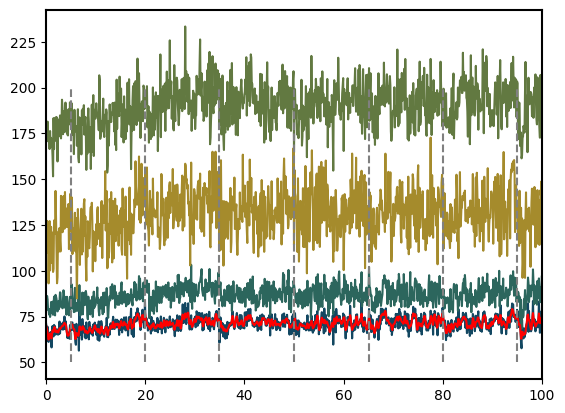

In [23]:
plt.plot(ts, vein1)
plt.plot(ts, vein2)
plt.plot(ts, still1-50)
plt.plot(ts, still2-100)
plt.plot(ts, gaussian_filter(vein1, sigma=1), color='red')
plt.vlines(ts[AP_idx], 50, 200, color='grey', linestyles='--')
plt.xlim(0, 100)

## 3D (frames)

### Open data

In [3]:
def identify_files(path, keywords):
    items = os.listdir(path)
    files = []
    for item in items:
        if all(keyword in item for keyword in keywords):
            files.append(item)
    files.sort()
    return files

def create_npy_stack(folder_path:str, save_path:str,  wl:int):
    """creates a 3D npy stack of raw tiff images

    Args:
        folder_path (str): folder containing tiff frames
        save_path (str): folder to save npy stack
        wl (int): wavelength for saved file name
    """
    files = identify_files(folder_path, "tif")
    # files=files[:250]
    for idx, file in tqdm(enumerate(files)):
        frame = tff.TiffFile(folder_path+"\\"+file).asarray()
        if idx == 0:
            num_frames = len(files)
            frame_shape = frame.shape
            stack_shape = (num_frames, frame_shape[0], frame_shape[1])
            _3d_stack = np.zeros(stack_shape, dtype=np.uint16)
        _3d_stack[idx,:,:] = frame

    np.save(save_path+"\\{}_rawStack.npy".format(wl), _3d_stack)


folder_path = r"Y:\gGermain\2024-07-18\785"
save_path = r"Y:\gGermain\2024-07-18"
wl = 785

# create_npy_stack(folder_path, save_path, wl)
# data = np.load(r"Y:\gGermain\2024-07-18\785_rawStack.npy")
# data = data[:200]
# print(data.shape)

(200, 987, 1079)


In [ ]:
##  WFMOVIE

# kernel_size = 9
# kernel = np.ones((kernel_size,kernel_size))/kernel_size**2
# data_LSCI = np.zeros(data.shape)
# for i,frame in tqdm(enumerate(data)):
#     mean = correlate(frame,kernel,mode = 'nearest')
#     std = np.sqrt(correlate(frame*frame,kernel,mode = 'nearest')-mean**2)
#     K = std/mean
#     data_LSCI[i,:,:] = std


## CLEROUX

def speckle_contrast(raw_speckle_data, window_size=7):
    num_frames, height, width = raw_speckle_data.shape
    contrast_data = np.zeros((num_frames, height, width), dtype=np.float32)

    for frame_idx in tqdm(range(num_frames)):
        frame_data = raw_speckle_data[frame_idx]

        # Calculate local mean and standard deviation for the current frame
        local_mean = uniform_filter(frame_data, size=window_size)
        local_variance = uniform_filter(frame_data**2, size=window_size) - local_mean**2
        local_std = np.sqrt(local_variance)
        
        # Calculate speckle contrast for the current frame
        contrast_data[frame_idx] = local_std / local_mean

    return contrast_data


print("Compute speckle")
static_data = np.array([np.mean(data, axis=0)])
static_data = speckle_contrast(static_data, window_size=7)

data_LSCI = speckle_contrast(data, window_size=15)
# data_LSCI = 1 / np.power(data_LSCI, 2)
# np.nan_to_num(data_LSCI, copy=False, nan=0.0, posinf=0.0, neginf=0.0)


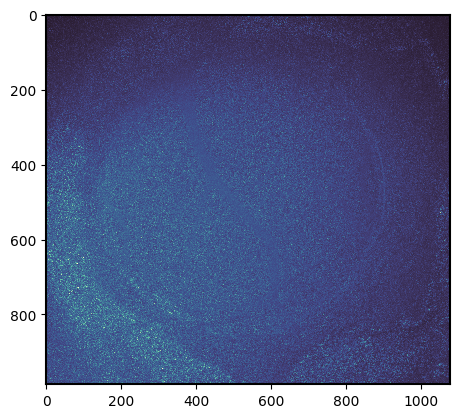

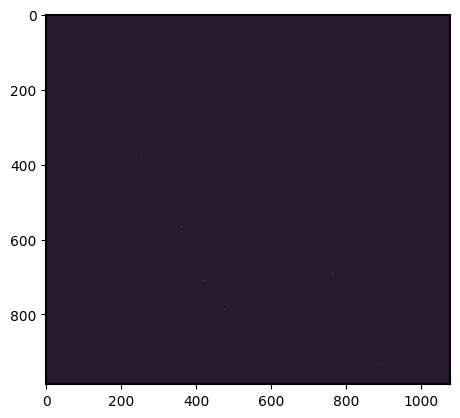

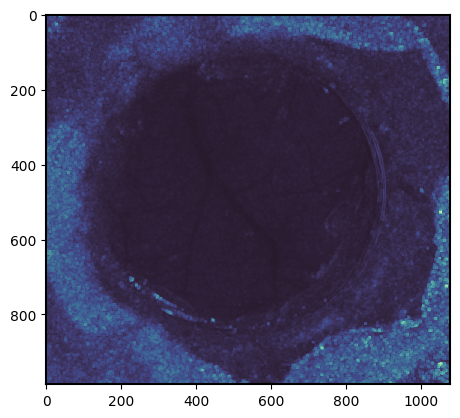

In [5]:
frame=10

plt.imshow(data[frame])
plt.show()
plt.imshow(data_LSCI[frame])
plt.show()
plt.imshow(static_data[0])

# print(data_LSCI.dtype)
# print(np.min(data_LSCI), np.max(data_LSCI))
# print(data.shape)